## Import Libraries

In [2]:
import os 
import torch.nn as nn
from torchsummary import summary
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, random_split
import random


from conv_layer import conv_layer
from RLFB import RLFB
from SUBP import SubPixelConvBlock
from Trainning_Loop import train_model, CharbonnierLoss

/home/user/miniforge3/envs/pytorch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Model Definition

In [3]:
class MESR(nn.Module):
    def __init__(self,in_channels,mid_channels,out_channels, num_blocks=12, upscale_factor=4):
        super(MESR, self).__init__()
        self.conv_in = conv_layer(in_channels, mid_channels, 3)
        self.RLFB_blocks = nn.Sequential(*[RLFB(mid_channels) for _ in range(num_blocks)])
        self.conv_out1 = conv_layer(mid_channels, mid_channels, 3)
        self.conv_out2 = conv_layer(mid_channels, out_channels, 3)
        self.sub_pixel_conv = SubPixelConvBlock(out_channels, out_channels, upscale_factor=upscale_factor)
    def forward(self, x):
        out_conv_in = self.conv_in(x)  
        out_RLFB = self.RLFB_blocks(out_conv_in)
        out2_conv_in = self.conv_out1(out_RLFB)  
        out_skip = out2_conv_in + out_conv_in  
        out = self.conv_out2(out_skip)  
        out = self.sub_pixel_conv(out)  
        return out
def model_summary(model, device):
    model.to(device)
    summary(model, input_size=(1, 128, 128)) # Change order & num of channels to match grayscale channel

## Data Loader

In [ ]:
class SuperResolutionDataset(Dataset):
    def __init__(self, lr_dir, hr_dir, lr_transform=None, hr_transform=None):
        self.lr_dir = lr_dir
        self.hr_dir = hr_dir
        self.lr_images = os.listdir(lr_dir)
        self.lr_transform = lr_transform
        self.hr_transform = hr_transform

    def __len__(self):
        return len(self.lr_images)

    def __getitem__(self, idx):
        lr_image_path = os.path.join(self.lr_dir, self.lr_images[idx])
        hr_image_path = os.path.join(self.hr_dir, self.lr_images[idx])

        lr_image = Image.open(lr_image_path).convert("L")  
        hr_image = Image.open(hr_image_path).convert("L")  

        if self.lr_transform:
            lr_image = self.lr_transform(lr_image)
        if self.hr_transform:
            hr_image = self.hr_transform(hr_image)

        return {'image': lr_image, 'label': hr_image}

## Hyperparamters

In [ ]:
def dataloaders(train_dataset, val_dataset, batch_size=32): # setting the batch size to 2
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


def setup_training(model, device, train_loader, val_loader, epochs=100, patience=10):
    optimizer = optim.AdamW(model.parameters(), lr=0.001)
    loss_function = CharbonnierLoss(epsilon=1e-6)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr=1e-6, verbose=True)



    train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        loss_function=loss_function,
        device=device,
        epochs=epochs,
        patience=patience,
        lr_scheduler=lr_scheduler,

        output_dir="model_output"  # Specify the output directory
    )


In [ ]:
import torch
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is being used. Device:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU instead of GPU.")

GPU is being used. Device: NVIDIA RTX A6000


## Training

CUDA is available!
Number of available GPUs: 1
Current device: 0
Device name: NVIDIA RTX A6000
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]             640
            Conv2d-2         [-1, 64, 128, 128]          36,928
              SiLU-3         [-1, 64, 128, 128]               0
           Dropout-4         [-1, 64, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          36,928
              SiLU-6         [-1, 64, 128, 128]               0
           Dropout-7         [-1, 64, 128, 128]               0
            Conv2d-8         [-1, 64, 128, 128]          36,928
              SiLU-9         [-1, 64, 128, 128]               0
          Dropout-10         [-1, 64, 128, 128]               0
           Conv2d-11         [-1, 64, 128, 128]           4,160
AdaptiveAvgPool2d-12             [-1, 64, 1, 1]               0
        

/home/user/miniforge3/envs/pytorch/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:70: FutureWarning: Importing `spectral_angle_mapper` from `torchmetrics.functional` was deprecated and will be removed in 2.0. Import `spectral_angle_mapper` from `torchmetrics.image` instead.
  _future_warning(


Validation Loss: 0.1255
Validation PSNR: 14.6344
Validation SSIM: 0.0772
Time taken for epoch 1: 47.9535 seconds
----------
epoch 2/100
Step 1/66, Charbonnier Loss: 0.1269, Pixel Loss: 0.1269, Combined Loss: 0.2538, Gradient Norm: 0.5224, Step time: 0.4946 sec
Step 2/66, Charbonnier Loss: 0.1263, Pixel Loss: 0.1263, Combined Loss: 0.2526, Gradient Norm: 0.4988, Step time: 0.4957 sec
Step 3/66, Charbonnier Loss: 0.1235, Pixel Loss: 0.1235, Combined Loss: 0.2471, Gradient Norm: 0.4787, Step time: 0.4927 sec
Step 4/66, Charbonnier Loss: 0.1203, Pixel Loss: 0.1203, Combined Loss: 0.2405, Gradient Norm: 0.4585, Step time: 0.4957 sec
Step 5/66, Charbonnier Loss: 0.1207, Pixel Loss: 0.1207, Combined Loss: 0.2414, Gradient Norm: 0.4453, Step time: 0.4924 sec
Step 6/66, Charbonnier Loss: 0.1196, Pixel Loss: 0.1196, Combined Loss: 0.2392, Gradient Norm: 0.4308, Step time: 0.4938 sec
Step 7/66, Charbonnier Loss: 0.1171, Pixel Loss: 0.1171, Combined Loss: 0.2341, Gradient Norm: 0.4172, Step time: 

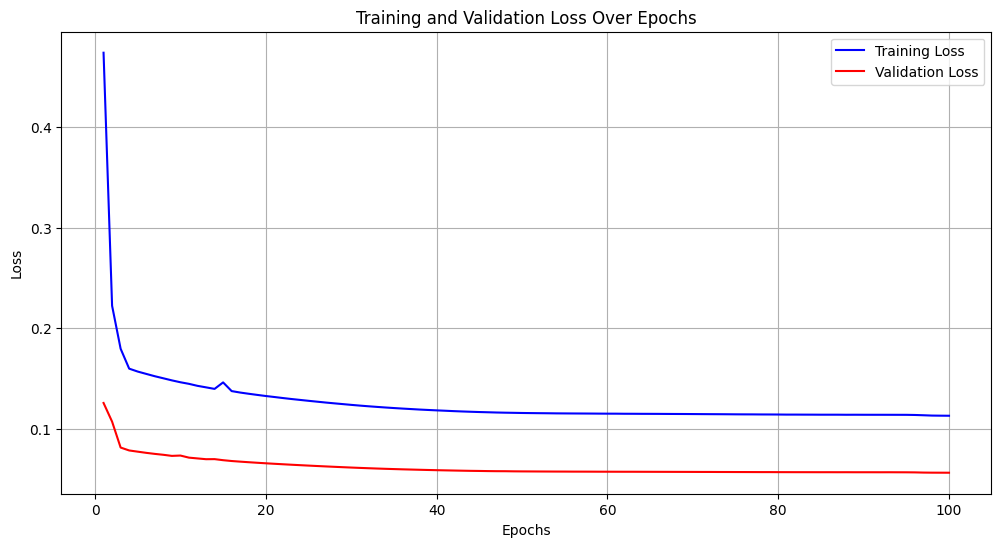

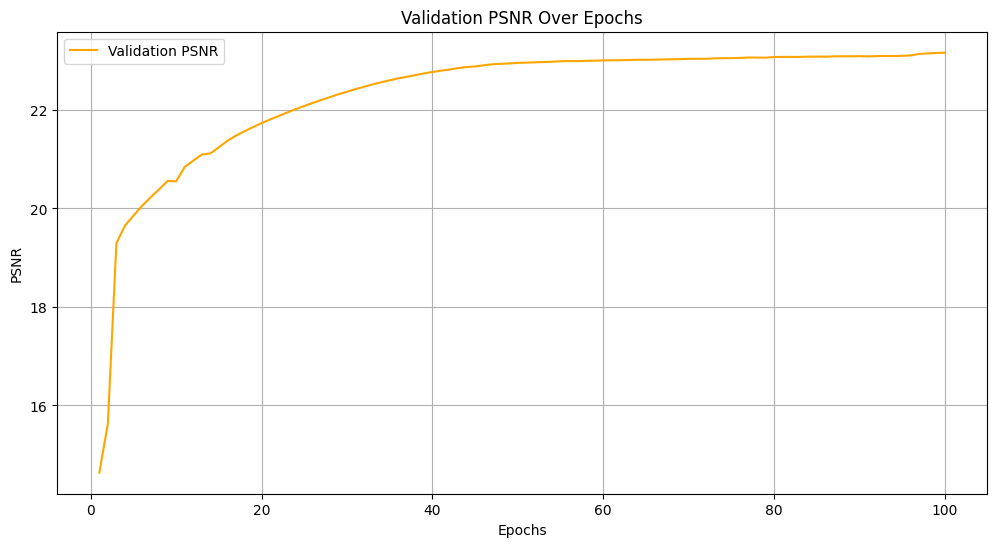

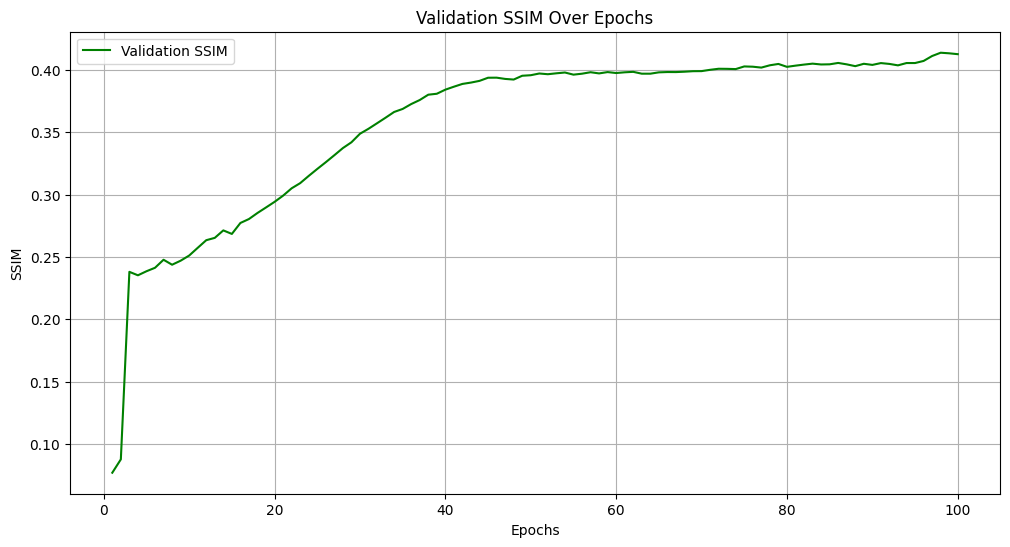

In [ ]:
def main():
    model = MESR(in_channels=1, mid_channels=52, out_channels=1, num_blocks=12)

    transform_lr = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: x / 255.0),  # Normalize to [0, 1]
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    transform_hr = transforms.Compose([
        transforms.ToTensor(),
        # transforms.Lambda(lambda x: x / 255.0),  # Normalize to [0, 1]
        #transforms.Normalize((0.5,), (0.5,))
    ])

    # Load the dataset
    lr_dir = "/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM/sdo patches/sdo patchs low res no copy"
    hr_dir = "/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM/sdo patches/sdo patches no copy"

    full_dataset = SuperResolutionDataset(
        lr_dir=lr_dir,
        hr_dir=hr_dir,
        lr_transform=transform_lr,
        hr_transform=transform_hr
    )


    # Splitting the dataset
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_loader, val_loader = dataloaders(train_dataset, val_dataset, batch_size=32)

    model_summary(model, device)
    setup_training(model, device, train_loader, val_loader)

main()


## Inferencing

In [9]:
model = MESR(in_channels=1, mid_channels=64, out_channels=1, num_blocks=12).to(device)
model.load_state_dict(torch.load("model_output/Feb28_0111/model_weight_epoch100.pth"))
# model.eval()


/tmp/ipykernel_4145469/3597073580.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model_output/Feb28_0111/model_weight_epoch100.pth"))


<All keys matched successfully>

In [12]:
from predict import prediction
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
    # transforms.Lambda(lambda x: x / 255.0),
])

def prediction(model, image_path):
    model.eval()
    image = Image.open(image_path).convert('L')
    image = transform(image).unsqueeze(0).to(device)
    with torch.inference_mode():
        output = model(image)
    return output.squeeze(0).cpu()


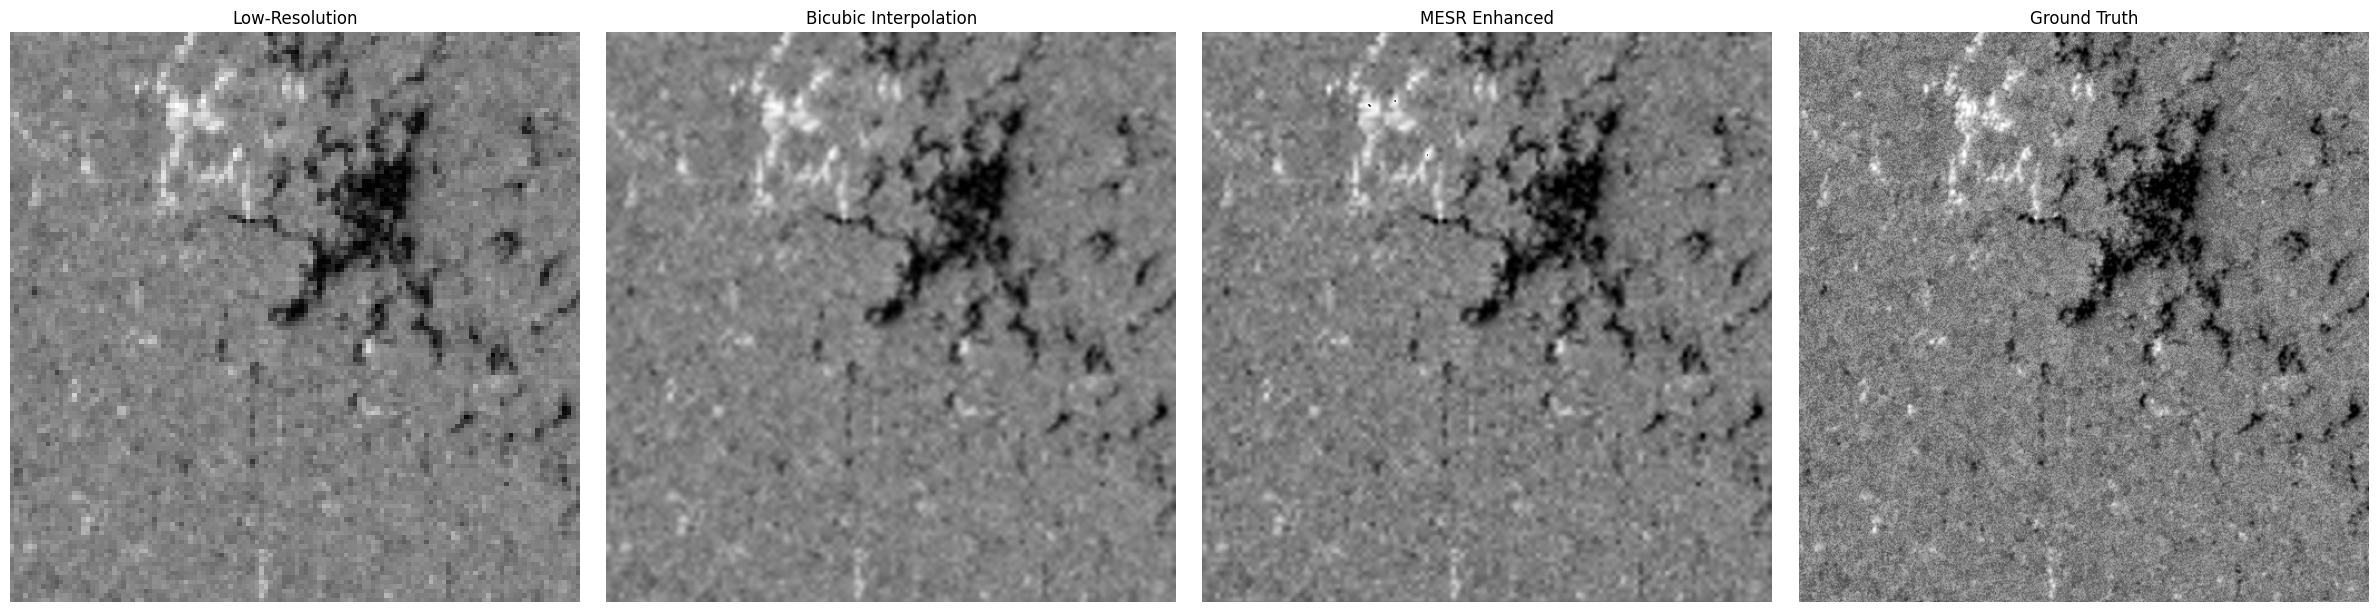

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
import cv2

# Example usage with visualization
low_res_image_path = '/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM NEW NEW/RESM/20100903_0025_hr_patch_11.jpg'  # Replace with your low-res image path
hr_image_path = '/media/user/9c7eaef1-35fa-4210-889c-9e2b99342586/user/abul/RESM/sdo patches/dataset sdo patches/20100903_0025_hr_patch_11.jpg'  # Replace with your high-res image path

# Get RESM enhanced image
predicted_image_tensor = prediction(model, low_res_image_path)
predicted_image_pil = transforms.ToPILImage()(predicted_image_tensor)  # Convert tensor to PIL image
predicted_image_np = np.array(predicted_image_pil)  # Convert PIL to NumPy array

# Load low-resolution image
low_res_pil = Image.open(low_res_image_path).convert('L')
low_res_np = np.array(low_res_pil)

# Load ground truth high-resolution image
hr_pil = Image.open(hr_image_path).convert('L')
hr_np = np.array(hr_pil)

# Perform bicubic interpolation
bicubic_np = cv2.resize(low_res_np, (predicted_image_np.shape[1], predicted_image_np.shape[0]), interpolation=cv2.INTER_CUBIC)

# Visualization using matplotlib
plt.figure(figsize=(24, 6))  # Adjust figure size as needed

# Subplot 1: Low-Resolution Image
plt.subplot(1, 4, 1)
plt.imshow(low_res_np, cmap='gray')
plt.title('Low-Resolution')
plt.axis('off')

# Subplot 2: Bicubic Interpolation Image
plt.subplot(1, 4, 2)
plt.imshow(bicubic_np, cmap='gray')
plt.title('Bicubic Interpolation')
plt.axis('off')

# Subplot 3: MESR Enhanced Image
plt.subplot(1, 4, 3)
plt.imshow(predicted_image_np, cmap='gray')
plt.title('RESM Enhanced')
plt.axis('off')

# Subplot 4: Ground Truth (High-Resolution) Image
plt.subplot(1, 4, 4)
plt.imshow(hr_np, cmap='gray')
plt.title('Ground Truth')
plt.axis('off')

plt.tight_layout()
plt.show()

# Optionally save the images
predicted_image_pil.save('path_to_save_predicted_image.png')
bicubic_pil = Image.fromarray(bicubic_np)
bicubic_pil.save('path_to_save_bicubic_image.png')
hr_pil.save('path_to_save_hr_image.png')


In [ ]:
predicted_image_tensor